In [40]:
import torch
import torch.nn as nn
import torch.optim as optim 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification

torch.manual_seed(42)
np.random.seed(42)

print('Torch version:', torch.__version__)

Torch version: 2.9.0+cpu


In [41]:
"""The Histogram Binning Calibrator with Torch."""


from __future__ import annotations

import torch
from torch import Tensor, device as TorchDevice, nn

from probly.calibration.template import CalibratorBaseTorch


class HistogramBinning(CalibratorBaseTorch):
    """Calibrator that uses histogram binning."""

    def __init__(self, base_model: nn.Module, device: TorchDevice, n_bins: int = 20) -> None:
        """Create a histogram binning calibrator."""
        super().__init__(base_model, device)
        self.n_bins = n_bins
        self.bin_start = 0.0
        self.bin_width = 0.0
        self.bin_probs : Tensor | None = None

    def fit(self, calibration_set: Tensor, truth_labels: Tensor) -> HistogramBinning:
        """Fit the histogram binning calibrator."""
        min_pre = calibration_set.min().item()
        max_pre = calibration_set.max().item()
        bin_width = (max_pre - min_pre)/self.n_bins

        if (max_pre == min_pre):
            bin_width = 1.0

        bin_counts = torch.zeros(self.n_bins, dtype=torch.int64)
        bin_positives = torch.zeros(self.n_bins, dtype=torch.int64)

        for pred, label in zip(calibration_set, truth_labels, strict=False):
            bin_id = int((pred.item() - min_pre)/bin_width)
            # Test for the case where bin id is equal to n_bins, making it out of bounds MIGHT REMOVE LATER
            bin_id = max(0, min(bin_id, self.n_bins - 1))
            if bin_id == self.n_bins:
                bin_id = self.n_bins - 1
            bin_counts[bin_id] += 1
            bin_positives[bin_id] += int(label.item())

        self.bin_probs = torch.zeros(self.n_bins)
        for i in range(self.n_bins):
            if bin_counts[i] > 0:
                self.bin_probs[i] = bin_positives[i].float()/bin_counts[i].float()
            else:
                self.bin_probs[i] = 0.0

        self.bin_start = min_pre
        self.bin_width = bin_width
        self.is_fitted = True
        return self

    def predict(self, predictions: Tensor) -> Tensor:
        """Return calibrated probabilities for input predictions."""
        if not self.is_fitted:
            msg = "Calibrator must be fitted before Calibration"
            raise ValueError(msg)

        calibrated = []

        for pred in predictions:
            bin_id = int((pred.item() - self.bin_start)/self.bin_width)
            bin_id = max(0, min(bin_id, self.n_bins - 1))

            if bin_id == self.n_bins:
                bin_id -= 1

            # Temporary fix for mypy issue: self.bin_probs could theoretically be None
            if self.bin_probs is None:
                msg = "HistogramBinning is not fitted"
                raise RuntimeError(msg)
            calibrated.append(self.bin_probs[bin_id])

        return Tensor(calibrated)

In [ ]:
# Create synthetic binary classification dataset
X, y = make_classification(
    n_samples = 2000, 
    n_features = 20, 
    n_informative = 10, 
    n_redundant = 2, 
    random_state = 42
)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
# Split into three sets:
# Training: 0-1500 (not used in this demo, for illustration)
# Calibration: 1500-1750 (used to fit the calibrator)
# Test: 1750-2000 (used to evaluate calibration performance) 
X_train, y_train = X[:1500], y[:1500]
X_cal, y_cal = X[1500:1750], y[1500:1750]
X_test, y_test = X[1750:], y[1750:]

print('shapes:', X_train.shape, X_cal.shape, X_test.shape)

shapes: torch.Size([1500, 20]) torch.Size([250, 20]) torch.Size([250, 20])


In [ ]:
# using ImageNet weights for demonstration
import torch
import torchvision.models as models

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#Load and preprocess CIFAR-10 test set with ImageNet normalization
from torchvision import datasets, transforms 
from torch.utils.data import DataLoader

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],      
        std=[0.229, 0.224, 0.225]
    ),
])

dataset = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=preprocess
)

loader = DataLoader(dataset, batch_size=32, shuffle=False)

In [ ]:
#Convert CIFAR-10 to binary: "cat" (class 3) vs. "not cat"
import torch

classes = ["airplane", "automobile", "bird", "cat", "deer", 
           "dog", "frog", "horse", "ship", "truck"]

target_class = 3  

all_images = []
binary_labels = []

for img, label in dataset:
    all_images.append(img)

    binary_labels.append(1 if label == target_class else 0)

all_images = torch.stack(all_images)         
binary_labels = torch.tensor(binary_labels)  

len(all_images), len(binary_labels)


(10000, 10000)

In [ ]:
#Extract softmax probabilities for ImageNet "tammy cat" class (281)
import torch.nn.functional as F

model.eval()

probs = []

with torch.no_grad():
    for imgs, labels in loader : 
        imgs = imgs 

        logits = model(imgs)

        softmaxed = F.softmax(logits, dim=1)

        cat_probs = softmaxed[:, 281]

        probs.append(cat_probs)
y_pred = torch.cat(probs)
y_pred[:10]

tensor([2.3401e-03, 6.1690e-05, 2.5171e-05, 7.8351e-04, 3.7442e-05, 8.1086e-05,
        1.0710e-05, 1.3688e-04, 6.1448e-03, 2.3763e-06])

In [ ]:
#Fit histogram binnig on calibration set, evaluate on test set
device = torch.device("cpu")
calibrator = HistogramBinning(base_model=model, device=device)

#Fit on CALIBRATION set
cal_preds = y_pred[1500:1750]
cal_labels = binary_labels[1500:1750]
calibrator.fit(cal_preds, cal_labels)

#Evaluate on TEST set
test_preds = y_pred[1750:]
test_labels = binary_labels[1750:]

test_preds_calibrated = calibrator.predict(test_preds)

print("Test predictions before calibration (first 10):")
print(test_preds[:10])

print("\nTest predictions **after** calibration (first 10):")
print(test_preds_calibrated[:10])

Test predictions before calibration (first 10):
tensor([7.8219e-06, 1.4629e-06, 1.6380e-05, 2.4401e-03, 1.0201e-03, 4.0285e-05,
        6.4416e-05, 3.0889e-04, 4.4791e-07, 1.5090e-05])

Test predictions **after** calibration (first 10):
tensor([0.0478, 0.0478, 0.0478, 0.0000, 0.6667, 0.0478, 0.0478, 0.0478, 0.0478,
        0.0478])


ECE before calibration: 0.0990
ECE after calibration:  0.0439


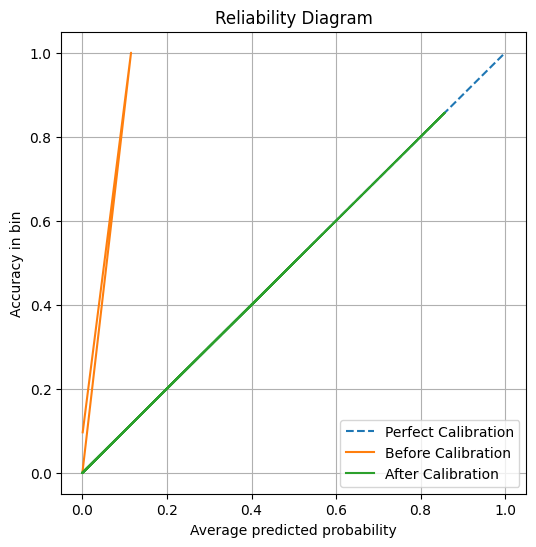

In [ ]:
#Compute ECE and plot reliability diagram on test set
import numpy as np
import matplotlib.pyplot as plt

#Function to compute ECE (Expected Calibration Error)
def compute_ece(preds, labels, n_bins=15):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        start, end = bins[i], bins[i+1]

        #pick predictions inside the bin
        in_bin = (preds >= start) & (preds < end)
        bin_size = in_bin.sum()

        if bin_size > 0:
            avg_pred = preds[in_bin].float().mean()
            avg_label = labels[in_bin].float().mean()

            #bin weight * absolute error
            ece += (bin_size / len(preds)) * abs(avg_pred - avg_label)

    return ece


#Compute ECE before & after calibration
ece_before = compute_ece(test_preds, test_labels)
ece_after  = compute_ece(test_preds_calibrated, test_labels)

print(f"ECE before calibration: {ece_before:.4f}")
print(f"ECE after calibration:  {ece_after:.4f}")


#Plot reliability diagram
def reliability_plot(raw, calibrated, labels, n_bins=15):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    def bin_stats(preds):
        conf = []
        acc = []
        for i in range(n_bins):
            in_bin = (preds >= bins[i]) & (preds < bins[i+1])
            if in_bin.sum() > 0:
                conf.append(preds[in_bin].float().mean())
                acc.append(labels[in_bin].float().mean())
            else:
                conf.append(0)
                acc.append(0)
        return np.array(conf), np.array(acc)

    raw_conf, raw_acc = bin_stats(raw)
    cal_conf, cal_acc = bin_stats(calibrated)

    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], '--', label="Perfect Calibration")
    plt.plot(raw_conf, raw_acc, label="Before Calibration")
    plt.plot(cal_conf, cal_acc, label="After Calibration")
    plt.xlabel("Average predicted probability")
    plt.ylabel("Accuracy in bin")
    plt.title("Reliability Diagram")
    plt.legend()
    plt.grid(True)
    plt.show()


# Draw the plot
reliability_plot(val_preds, val_preds_calibrated, val_labels)
